<a href="https://colab.research.google.com/github/binaria010/Pricing-Theory/blob/main/AmericanBermudanOptions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<head>
  <script type="text/x-mathjax-config"> MathJax.Hub.Config({ TeX: { equationNumbers: { autoNumber: "all" } } }); </script>
  <script type="text/x-mathjax-config">
    MathJax.Hub.Config({
      tex2jax: {
        inlineMath: [ ['$','$'], ["\\(","\\)"] ],
         displayMath: [ ['$$','$$'], ["\\[","\\]"] ],
         processEscapes: true
      }
    });
  </script>
  <script src="https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML" type="text/javascript"></script>
  <meta name="google-site-verification" content="kuks5e4as6qBaGVCSzmHkQJa5Tss89_g5DmRXeUi7K8" />
</head>



<h1> Pricing American/Bermudan options. </h1>

In this notebook we implement some of the methods for pricing american/bermudan options. The first approach is to price a bermudan option by means of Least Square Monte Carlo method which roughly speaking consists on estimating the price by estimating the expected value using a linear regression with a specified set of basis functions. Since, one can se an american option as a limit of a bermuda option (a limit to infinity of the exercise dates), then this method allows us, by taking the number of exercising dates to be big, to price american options as well.

The second approach is the PDE method. We present the partial differential equation with free boundary  and implement implicit and explicit schemes to find approximate solutions.

In both cases we are under the Black-Scholes model.

<h2> Least squares Monte Carlo method to price a Bermudan option</h2>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.linear_model import LinearRegression
import pandas as pd
import scipy.sparse



In [ ]:
class GBM:

    def __init__(self, interest_rate, dividend_yield, volatility):

        self.interest_rate = interest_rate
        self.dividend_yield = dividend_yield
        self.volatility = volatility


    def Paths(self, S_0, num_intervals, T_final, Num_sim):
        r = self.interest_rate
        d = self.dividend_yield
        sigma = self.volatility
        h = T_final/num_intervals
        S = np.zeros((Num_sim, num_intervals + 1))
        S[:, 0] = S_0

        for t in range(1, num_intervals + 1):
            Z = scipy.stats.norm.rvs(loc = 0, scale = 1, size = Num_sim)
            S[:, t] = S[:, t-1]*np.exp(((r-d) - 0.5*sigma**2)*h + sigma*np.sqrt(h)*Z)

        return S


In [ ]:
def compute_C_hat(X, features,  y):
    """
    returns the coefficients of linear regression
    """

    phi_X = np.array([func(X) for func in features]).T
    lin_reg = LinearRegression(fit_intercept=False).fit(phi_X,y)
    C_hat = lin_reg.predict(phi_X)

    return C_hat

In [ ]:
def time_zero_price_Bermuda_Put(X, payoff,T, r, features, method, N_sim = 10**5):

    m = X.shape[1] - 1
    h = T/m
    V_hat = np.zeros((N_sim, m+1))
    V_hat[:, m] = np.exp(-r*m*h)*payoff(X[:, m])

    for j in range(m-1,0,-1):
        C_hat_j = compute_C_hat(X = X[:, j], features = features, y= V_hat[:, j+1])
        discounted_payoff = np.exp(-r*j*h)*payoff(X[:, j])
        if method == "Tsits-VanRoy":
            V_hat[:, j] = np.maximum(discounted_payoff, C_hat_j)
        if method == "Long-Sch":
            condition = discounted_payoff > C_hat_j
            V_hat[:, j] = discounted_payoff*(condition) + V_hat[:, j+1]*(~condition)

    V_0 = np.mean(V_hat[:, 1])

    return V_0



* Example 1.

In [ ]:
N_sim = 10**5
m = 50  # number of exercising dates
s_0 = 1
r = 0.1
sigma = 0.2
K = 1.0
T = 1


# payoff
payoff = lambda s: np.maximum(K - s, 0)

# features
deg = 4

def foo(deg):
    f = lambda x: x**deg

    return f

Phi = [foo(d) for d in range(deg+1)]


# paths:
model = GBM(r, 0, sigma)
X = model.Paths(S_0 = s_0, T_final = T, num_intervals = m, Num_sim = N_sim)



In [ ]:
Tsit_VR = time_zero_price_Bermuda_Put(X, payoff=payoff, T=T, r=r, features=Phi, method = "Tsits-VanRoy" )
LongS = time_zero_price_Bermuda_Put(X, payoff=payoff, T=T, r=r, features=Phi, method = "Long-Sch" )


In [ ]:
print(f"The zero time price of this Bermudan put option with {m} dates of exercising is: ")
print(f"With the Tsitsilkis-Van Roy method: {Tsit_VR}")
print(f"With the Longstaff-Schwartz method: {LongS}")

The zero time price of this Bermudan put option with 50 dates of exercising is: 
With the Tsitsilkis-Van Roy method: 0.055158800038482975
With the Longstaff-Schwartz method: 0.04643059553856469


Now, taking $m$, the number of exercising dates to be ten times bigger the zero time price of the option is:

In [ ]:
# paths:
model = GBM(r, 0, sigma)
X = model.Paths(S_0 = s_0, T_final = T, num_intervals = 10*m, Num_sim = N_sim)

Tsit_VR_10m = time_zero_price_Bermuda_Put(X, payoff=payoff, T=T, r=r, features=Phi, method = "Tsits-VanRoy" )
LongS_10m = time_zero_price_Bermuda_Put(X, payoff=payoff, T=T, r=r, features=Phi, method = "Long-Sch" )


In [ ]:
print(f"The zero time price of this Bermudan put option with {10*m} dates of exercising is: ")
print(f"With the Tsitsilkis-Van Roy method: {Tsit_VR_10m}")
print(f"With the Longstaff-Schwartz method: {LongS_10m}")

The zero time price of this Bermudan put option with 500 dates of exercising is: 
With the Tsitsilkis-Van Roy method: 0.05729517017535481
With the Longstaff-Schwartz method: 0.045319501107950855


Meanwhile the time zero price of European put is:

In [ ]:
def Exact_price_European_Put(S_0, K, r, sigma, T):

    d1 = (np.log(S_0/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = (np.log(S_0/K) + (r - 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    value = -S_0*scipy.stats.norm.cdf(-d1,loc= 0, scale=1) + K*np.exp(-r*T)*scipy.stats.norm.cdf(-d2,loc= 0, scale=1)

    return value

exact_value = Exact_price_European_Put(s_0, K, r, sigma, T)
print(exact_value)

0.03753418388256835


------------------------------

_____________________________

* <strong> Example 2.</strong> <em> American max option. </em> This option has at time $t$ the undiscounted payoff
$$
\tilde{h}(S_1(t), S_2(t)) = (\max{S_1(t), S_2(t)} - K)^{+}
$$

where the assets $S_1, S_2$ are modeled by the geometric Brownian motion with $r = 0.05$, dividend yiled $\delta=0.1$ and volatility $\sigma = 0.2$. The two assets are mutually independent. The strike value $K=100$ and $S_1(0)=S_2(0) = 100$ and maturity $T=3$ years. The option can be exercised at nine equally spaced dates $t_i = i/3$, $i=1,2,\dots, 9$.

In [ ]:
def compute_C_hat_for_max(phi_X, y):
    """
    returns the coefficients of linear regression
    """
    lin_reg = LinearRegression(fit_intercept=False).fit(phi_X,y)
    C_hat = lin_reg.predict(phi_X)

    return C_hat

def time_zero_price_American_max(model, num_assets, s_0, m, payoff,T, K,features, method, N_sim = 10**5):

    """
    Parameters:

    model (class): an instance of the class modelling the assets
    nu_assets (int): number of assets
    s_0 (float): initial state
    m (int): number of exercising dates
    payoff (function): the payoff function
    T (float): maturity time
    features (list): a list of the basis functions for the regression
    method (string): the method to compute the estimated price ("Tsits-VanRoy", "Long-Sch")
    N_sim (int): number of simulations for the montecarlo
    """

    assets = []
    for n in range(num_assets):
        S = model.Paths(s_0, m,T, N_sim)
        assets.append(S)


    h = T/m
    X = np.hstack([assets[i][:, m].reshape(-1,1) for i in range(num_assets)])
    V_hat = np.zeros((N_sim, m+1))
    V_hat[:, m] = np.exp(-r*m*h)*payoff(X, K)

    for j in range(m-1,0,-1):
        X = np.hstack([assets[i][:, j].reshape(-1,1) for i in range(num_assets)])
        phi_X = np.hstack([func(X) for func in features])
        C_hat_j = compute_C_hat_for_max(phi_X, y= V_hat[:, j+1])
        discounted_payoff = np.exp(-r*j*h)*payoff(X,K)

        if method == "Tsits-VanRoy":
            V_hat[:, j] = np.maximum(discounted_payoff, C_hat_j)
        if method == "Long-Sch":
            condition = discounted_payoff > C_hat_j
            V_hat[:, j] = discounted_payoff*(condition) + V_hat[:, j+1]*(~condition)

    V_0 = np.mean(V_hat[:, 1])

    return V_0

In [ ]:
T = 3
r = 0.05
delta = 0.1
sigma = 0.2
Nsim = 4*10**3
s_0 = 100
m = 9

# features
deg = 3

def foo(deg):
    f = lambda x: x**deg

    return f
def constant_foo():
    return lambda x: np.ones(x.shape)

Phi = [foo(d) for d in range(1,deg+1)] + [constant_foo()]

# payoff

def payoff_max(X, K):
    return np.maximum(np.max(X, axis = 1) - K  ,0)


# model for the assets
model = GBM(r, delta, sigma)

In [ ]:
Tsit_VanRoy = time_zero_price_American_max(model, num_assets =2, s_0 = s_0, m = m ,payoff = payoff_max,T =T, K = K,features = Phi, method ="Tsits-VanRoy", N_sim = 10**5)
Long_sch = time_zero_price_American_max(model, num_assets =2, s_0 = s_0, m = m ,payoff = payoff_max,T =T, K = K,features = Phi, method ="Long-Sch", N_sim = 10**5)

In [ ]:
print(f" Tsitsitkils Van Roy is {Tsit_VanRoy}")
print(f"Longstaff Schwartz is {Long_sch}")

 Tsitsitkils Van Roy is 104.63400546691578
Longstaff Schwartz is 102.49314822667444


Let us use more basis functions such as:

* $\{1,~ x^i,~ y^i,~ xy ~, \text{for } i =1,2,3\}$
* $\{1,~ x^i,~ y^i,~ xy ~, \max(x, y), ~ \text{for } i =1,2,3\}$
* $\{1,~ x^i,~ y^i,~ xy,~ x^2y,~ xy^2, \text{for } ~ i =1,2,3\}$

In [ ]:
interaction = lambda X: (X[:,0]*X[:,1]).reshape(-1,1)

max_function = lambda X: np.max(X, axis = 1, keepdims = True)

def cubic_foos():
    return [lambda X: (X[:, 0]**2 * X[:, 1]).reshape(-1,1), lambda X: (X[:, 0]*X[:, 1]**2).reshape(-1,1)]


Phi1 = Phi + [interaction]
Phi2 = Phi1 + [max_function]
Phi3 = Phi1 + cubic_foos()


In [ ]:
Tsit_VanRoy1 = time_zero_price_American_max(model, num_assets =2, s_0 = s_0, m = m ,payoff = payoff_max,T =T, K = K,features = Phi1, method ="Tsits-VanRoy", N_sim = 10**5)
Long_sch1 = time_zero_price_American_max(model, num_assets =2, s_0 = s_0, m = m ,payoff = payoff_max,T =T, K = K,features = Phi1, method ="Long-Sch", N_sim = 10**5)

In [ ]:
print("The estimated price for the basis functions {1, x^i,  y^i,  xy, for i =1,2,3} are:")
print(f" Tsitsitkils Van Roy is {Tsit_VanRoy1}")
print(f"Longstaff Schwartz is {Long_sch1}")

The estimated price for the basis functions {1, x^i,  y^i,  xy, for i =1,2,3} are:
 Tsitsitkils Van Roy is 103.22672225724922
Longstaff Schwartz is 102.74065341264286


In [ ]:
Tsit_VanRoy2 = time_zero_price_American_max(model, num_assets =2, s_0 = s_0, m = m ,payoff = payoff_max,T =T, K = K,features = Phi2, method ="Tsits-VanRoy", N_sim = 10**5)
Long_sch2 = time_zero_price_American_max(model, num_assets =2, s_0 = s_0, m = m ,payoff = payoff_max,T =T, K = K,features = Phi2, method ="Long-Sch", N_sim = 10**5)

In [ ]:
print("The estimated price for the basis functions {1, x^i,  y^i,  xy, max(x,y) for i =1,2,3} are:")
print(f" Tsitsitkils Van Roy is {Tsit_VanRoy2}")
print(f"Longstaff Schwartz is {Long_sch2}")

The estimated price for the basis functions {1, x^i,  y^i,  xy, max(x,y) for i =1,2,3} are:
 Tsitsitkils Van Roy is 102.69775268900071
Longstaff Schwartz is 102.7326909560943


In [ ]:
Tsit_VanRoy3 = time_zero_price_American_max(model, num_assets =2, s_0 = s_0, m = m ,payoff = payoff_max,T =T, K = K,features = Phi3, method ="Tsits-VanRoy", N_sim = 10**5)
Long_sch3 = time_zero_price_American_max(model, num_assets =2, s_0 = s_0, m = m ,payoff = payoff_max,T =T, K = K,features = Phi3, method ="Long-Sch", N_sim = 10**5)


In [ ]:

print("The estimated price for the basis functions {1, x^i,  y^i,  xy, x^2y, xy^2 for i =1,2,3} are:")
print(f" Tsitsitkils Van Roy is {Tsit_VanRoy3}")
print(f"Longstaff Schwartz is {Long_sch3}")

The estimated price for the basis functions {1, x^i,  y^i,  xy, x^2y, xy^2 for i =1,2,3} are:
 Tsitsitkils Van Roy is 103.11513376953486
Longstaff Schwartz is 102.80388673481086


Let us print all the results in a dataframe incluiding estimates for initial stock price of $S_0 = 90$ (in-the-money) and $S_0 = 110$ (out-of-the-money).

In [ ]:
S0 = [100.0, 90.0, 110.0]
Basis_functions = [Phi, Phi1, Phi2,Phi3]
columns = ["T-VR", "L-S"]
basis_func_names = ["1,S_i, S_i^2, S_i^3", "1,S_i, S_i^2, S_i^3, S_1S_2", "1,S_i, S_i^2, S_i^3, S_1S_2, max(S_1,S_2)", "1,S_i, S_i^2, S_i^3, S_1S_2, S_1^2S_2, S_1S_2^2"]

results = pd.DataFrame({}, columns = columns, index = basis_func_names)
results.index.name = "Basis functions"
results_in_the_money = pd.DataFrame({}, columns = columns, index = basis_func_names)
results_in_the_money.index.name = "Basis functions"
results_out_the_money = pd.DataFrame({}, columns = columns, index = basis_func_names)
results_out_the_money.index.name = "Basis functions"


In [ ]:
r = 0.05
delta = 0.1
sigma = 0.2
m = 9
T = 3.0
K = 100.0

model = GBM(r, delta, sigma)


In [ ]:
for i, features in enumerate(Basis_functions):

    TVR = time_zero_price_American_max(model, num_assets=2, s_0 = S0[0], m = m, payoff=payoff_max, T = T, K = K, features=features, method="Tsits-VanRoy")
    LS = time_zero_price_American_max(model, num_assets=2, s_0 = S0[0], m = m, payoff=payoff_max, T = T,  K = K, features=features,method="Long-Sch")
    TVR_in_money = time_zero_price_American_max(model, num_assets=2, s_0 = S0[1], m = m, payoff=payoff_max, T = T, K = K, features=features, method="Tsits-VanRoy")
    LS_in_moey = time_zero_price_American_max(model, num_assets=2, s_0 = S0[1], m = m, payoff=payoff_max, T = T,  K = K, features=features,method="Long-Sch")
    TVR_out_money = time_zero_price_American_max(model, num_assets=2, s_0 = S0[2], m = m, payoff=payoff_max, T = T, K = K, features=features, method="Tsits-VanRoy")
    LS_out_moey = time_zero_price_American_max(model, num_assets=2, s_0 = S0[2], m = m, payoff=payoff_max, T = T,  K = K, features=features,method="Long-Sch")

    results.loc[basis_func_names[i]] = [TVR, LS]
    results_in_the_money.loc[basis_func_names[i]] = [TVR_in_money, LS_in_moey]
    results_out_the_money.loc[basis_func_names[i]] = [TVR_out_money, LS_out_moey]


In [ ]:
print(results)
print('\n')
print("In-the-money")
print('\n')
print(results_in_the_money)
print('\n')
print("Out-of-the-money")
print('\n')
print(results_out_the_money)


                                                      T-VR        L-S
Basis functions                                                      
1,S_i, S_i^2, S_i^3                              15.574006  13.657911
1,S_i, S_i^2, S_i^3, S_1S_2                      15.206147  13.681587
1,S_i, S_i^2, S_i^3, S_1S_2, max(S_1,S_2)        15.195438  13.618971
1,S_i, S_i^2, S_i^3, S_1S_2, S_1^2S_2, S_1S_2^2  14.935285  13.725129


In-the-money


                                                     T-VR       L-S
Basis functions                                                    
1,S_i, S_i^2, S_i^3                              9.478431   7.90573
1,S_i, S_i^2, S_i^3, S_1S_2                      9.327884  7.838965
1,S_i, S_i^2, S_i^3, S_1S_2, max(S_1,S_2)        9.333072  7.868149
1,S_i, S_i^2, S_i^3, S_1S_2, S_1^2S_2, S_1S_2^2  9.262682  7.869341


Out-of-the-money


                                                      T-VR        L-S
Basis functions                                                 

_______________________________
__________________________________

<h3> PDE approach to price the american put. </h2>

The price $V(t,s)$ of an american put satisfies the <em>Linear Complementary Problem </em> (LCP):

$$
\frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2 s^2\frac{\partial ^2 V}{\partial s^2} + rs\frac{\partial V}{\partial s} - rV =0\qquad s > B(t), \quad t\in[0, T]
$$

Here $B(t)$ is the moving boundary. Also we are assuming that no dividends are paid throughout the life of the option.

The terminal condition is given by:

$$
V(T, s) = \max(K - s, 0), \quad x\geq 0
$$

and boundary conditions:

$$
\begin{align*}
\lim_{s\to \infty}V(t, s) &= 0\\
\frac{\partial V}{\partial s}(t, B(t)) &=  -1\\
V(t, B(t)) &=  K - B(t)\\
\end{align*}
$$

Define also a terminal value for the boundary function

$$
B(T) = K
$$

Finally, "in front" of the free boundary the option price is given by:

$$
V(t, s) = \max(K -s, 0), \quad 0\leq s < B(t).
$$

Now, since early exercise is permitted, the option price must satisfy the constrain:

$$
V(t, s) \geq \max(K - s, 0), \quad s \geq 0, \quad t\in[0,T].
$$

In conclusion, for this problem we have two unknowns, namely the option price function $V$ and the free boundary $B$. The curve $B$ is called the optimal exercise boundary. In the region $s > B(t)$, the option price satisfies the Black-Scholes equation, while in the region $s\leq B(t)$, it is optimal to exercise the put.

To solve this problem we will use the <strong>Fron-Fixing method</strong>. The idea is to apply a transformation of variables in order to remove the free boundary at the cost of adding a complexity to the PDE, namely a non-linearity to the equation.

The Landau trasnformation is:

$$
x = \frac{s}{B(t)}
$$

Then, by applying chain rule, the Black-Schole equation in the new variables $(t,x)$ is:

$$
\frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2 x^2\frac{\partial ^2 V}{\partial x^2} + x \left[r - \frac{B'(t)}{B(t)}\right]\frac{\partial V}{\partial x} - rV  =0 \qquad 1< x <+\infty(t), \quad t\in[0, T]
$$

subject to:

$$
\begin{align*}
& V(T, x)  = 0, \quad x\geq 1\\
& \lim_{x\to \infty}V(t, x) = 0\\
&\frac{\partial V}{\partial x}(t, 1) =  -B(t)\\
& V(t, 1) =  K - B(t)\\
&B(T) = K
\end{align*}
$$

Once $V$ and $B$ are computed, the time $t$ value of the American put is given by

$$
P(t, S) = \begin{cases}
V(t, S/B(t))  \quad &\text{if } \tfrac{S}{B(t)} \geq 1\\
\\
K - S \quad &\text{if }  0 \leq \tfrac{S}{B(t)}< 1
\end{cases}
$$

<h2> Numerical solution. </h2>

<h3> Implicit scheme. </h3>

Now we proceed to find an approximate solution by means of the Implicit Euler scheme:

$$
\frac{V^{i+1}_{j}-V^{i}_{j}}{\Delta t} + \frac{1}{2}\sigma^2x_j^2\frac{V_{j+1}^{i}-2V_{j}^{i} + V_{j-1}^{i}}{\Delta x^2} + x_j\left[r - \frac{B^{i+1} - B^{i}}{\Delta tB^{i}}\right]\frac{V_{j+1}^{i}-V_{j-1}^{i}}{2\Delta x} - rV_{j}^{i} = 0 \qquad i= N_t, N_{t}-1,\dots, 0,\quad j = 1,2,\dots, N_x
$$

where as usual $V^{i}_{j}=V(t_i, x_j), B^{i} = B(t_i)$, $\Delta t, \Delta x$ are the sizes of the grids in $t$ and $x$ respectively and $N_t, N_x$ the number of nodes in each coordinate.

Note that since the unknown function $B$ is evaluated at time level $i$ and is multiplying the unknown function $V$ at the same time level, this system of equations is non-linear and we will need a solver such as Newton method to find the solutions. The advantange of using the explicit scheme is that the resulting system is linear, but we have the constraint of stability of the method.

The terminal conditions are:

$$
\begin{align*}
V^{N_t}_{j} &= 0, \quad j=0,1,\dots, N_x\\
B^{N_t} &= K
\end{align*}
$$

and the boundary conditions are:

$$
\begin{align*}
V^{i}_{0} &= K - B^{i}\\
V^{i}_{N_x} &= 0, \quad i = N_t,N_t -1,\dots, 0\\
\frac{V^{i}_{1}-V^{i}_{0}}{N_x} & = -B^{i}, \quad i = N_t, N_t-1,\dots, 0
\end{align*}
$$

From this last equation we can express $V_1^{i}$ in terms of $B^{i}$ by:

$$
V_1^{i} = V_0^{i} -\Delta x B^{i} = K - (1+\Delta x)B^{i}
$$

Then, $V_0^{i}, V_1^{i}$ can be computed in terms of $B^{i}$ for all $i=N_t-1, \dots, 0$.

For the rest of the unknwons $V_2^{i}, V_3^{i},\dots V_{N_x -1}^{i}, B^{i}$ we use the following equation:
$$
c_{j, j-1}V_{j-1}^{i}  + c_{j,j}V_{j}^{i} + c_{j,j+1}V_{j+1}^{i} = b_j
$$

with

$$\begin{align*}
c_{j,j-1} = & -  \frac{\Delta t}{2\Delta x^2}\sigma^2x_j^2 + \frac{\Delta t}{2\Delta x}x_j\left(r - \frac{B^{i+1} - B^{i}}{\Delta t B^{i}} \right)\\
\\
c_{j,j} = &1 + \frac{\Delta t}{\Delta x^2}\sigma^2x_j^2 +r\Delta t\\
\\
c_{j,j+1} = & -\frac{\Delta t}{2\Delta x^2}\sigma^2x_j^2 - \frac{\Delta t}{2\Delta x}x_j\left(r - \frac{B^{i+1} - B^{i}}{\Delta t B^{i}} \right)\\
\\
b_j= & V_j^{i+1}
\end{align*}
$$





We now express the problem in the form of $F(V^i, B^i) = 0$ to apply Newton's method. From the equation we have that:

$$
F({\bf V}^{i}, {\bf B}^{i}) := C({\bf B}^{i}){\bf V}^{i} - f({\bf B}^{i}) = 0
$$

where ${\bf V}^i = (V_2^{i}, V_3^{i}, \dots, V_{N_x-1}^{i})$ for $i =N_t-1, \dots, 0$.

Below we give the python functions we defined to compute the solution of the equation using the Newton method:

In [ ]:
def auxiliar_funcs(Y, X_next, Y_next, params):

    """
    Y := B^{n} boundary function at time level n
    X, X_next: numpy arrays of dim M-1: having the variables V_2,V_3,..., V_{M}
    """

    r, sigma, K, T, x_0, x_inf , delta_t, delta_x,  = params

    M = int((x_inf - x_0)/delta_x) - 1
    b = np.hstack((K - (1+delta_x)*Y_next ,X_next))
    x = np.linspace(x_0, x_inf, M+2)  # dim x = M+2

    alpha = 1 + delta_t/(delta_x**2)*(sigma*x[1:-1])**2 +r*delta_t
    beta = delta_t/(2*delta_x)*x[1:-1] *((-1/delta_x) * sigma**2 * x[1:-1] + r - (1/delta_t)*(Y_next/Y - 1))
    gamma = delta_t/(2*delta_x)*x[1:-1] *(-1/delta_x*sigma**2*x[1:-1] - r + (1/delta_t)*(Y_next/Y - 1))

    alpha_prime = np.zeros_like(alpha)
    beta_prime = x[1:-1]/(2*delta_x)*Y_next*(1/Y**2)
    gamma_prime = -x[1:-1]/(2*delta_x)*Y_next *(1/Y**2)



    f = np.zeros(M)
    f[0] = b[0] - beta[0]*(K-Y) - alpha[0]*(K - (1+delta_x)*Y)
    f[1] = b[1] - beta[1]*(K - (1+delta_x)*Y)
    f[2:] = b[2:]

    f_prime = np.zeros(M)
    f_prime[0] = -beta_prime[0]*(K - Y) + beta[0] + alpha[0]*(1+delta_x)
    f_prime[1] = -beta_prime[1]*(K - (1+delta_x)*Y) + (1+delta_x)*beta[1]

    main_diag = gamma[0:-1]
    sub_diag = alpha[1:]
    sub_sub_diag = beta[2:]
    offsets = [0,-1,-2]

    A = scipy.sparse.diags([main_diag, sub_diag,sub_sub_diag], offsets=offsets, shape=(M, M-1)).toarray()

    main_diag_prime = gamma_prime[0:-1]
    sub_diag_prime = alpha_prime[1:]
    sub_sub_diag_prime = beta_prime[2:]

    A_prime = scipy.sparse.diags([main_diag_prime, sub_diag_prime, sub_sub_diag_prime], offsets=offsets, shape=(M, M-1)).toarray()

    return A, f, A_prime, f_prime

def F_function(X, Y, X_next, Y_next, params):

    A, f, _, _ = auxiliar_funcs(Y, X_next, Y_next, params)
    F = A @ X - f
    return F


def Jacobian_F(X, Y, X_next, Y_next, params):

    A, f, A_prime, f_prime = auxiliar_funcs(Y, X_next, Y_next, params)

    A_ext = np.hstack((A, np.zeros((A.shape[0], 1))))  # dim MxM
    last_column  = A_prime @ X - f_prime
    DF = A_ext + np.hstack((np.zeros_like(A), last_column.reshape(-1,1)))

    return DF

def Newton_method(F, DF, X0, Y0, X_next, Y_next, params, tol = 1e-6, max_iter = 50):

    X = X0.copy()
    Y = Y0.copy()

    for _ in range(max_iter):
        Fp = F(X, Y, X_next, Y_next, params)
        DFp = Jacobian_F(X, Y, X_next, Y_next, params)
        delta = np.linalg.solve(DFp, -Fp)
        X = X + delta[0:-1]
        Y = Y + delta[-1]
        if np.linalg.norm(delta) < tol:
            break

    return X, Y


In [ ]:
def implicit_method_for_American_put(F, DF, params):

    r, sigma, K, T, x_0, x_inf , delta_t, delta_x,  = params

    M = int((x_inf - x_0)/delta_x) -1
    N = int(T/delta_t) -1


    # save solutions (V_0, V_1, V_2,V_3,..., V_M)^n, B^n in matrices XX and YY respectively
    V = np.zeros((M+2, N +2))  # saves V_0, V_1,V_2,V_3,.., V_M for all n = N+1, N, N-1, .., 0

    B = np.zeros(N + 2)
    B[-1] = K

    for n in range(N, -1, -1):

        V_next = V[2:-1,n+1]
        B_next = B[n+1]
        #initial guess:
        X0 = V_next
        Y0 = B_next
        V[2:-1, n], B[n] = Newton_method(F, DF, X0, Y0, V_next, B_next, params)

    V[0, 0:-1] = K - B[0:-1]
    V[1, 0:-1] = K - (1+delta_x) * B[0:-1]

    return V, B





In [ ]:
sigma = 0.2
r = 0.1
K = 1
x_inf = 2
x_0 = 1
T = 1
delta_x = 1e-3
delta_t = 1e-3

params = [r, sigma, K, T, x_0, x_inf, delta_t, delta_x]


In [ ]:
V_implicit, B_implicit = implicit_method_for_American_put(F_function, Jacobian_F, params)



In [ ]:
print(B_implicit[0])

0.8611543951505038


--------------------------------
---------------------------------

<h2> Explicit method </h2>

In this case the discretized equation is of the form:

$$
\frac{V^{i+1}_{j}-V^{i}_{j}}{\Delta t} + \frac{1}{2}\sigma^2x_j^2\frac{V_{j+1}^{i+1}-2V_{j}^{i+1} + V_{j-1}^{i+1}}{\Delta x^2} + x_j\left[r - \frac{B^{i+1} - B^{i}}{\Delta tB^{i+1}}\right]\frac{V_{j+1}^{i+1}-V_{j-1}^{i+1}}{2\Delta x} - rV_{j}^{i+1} = 0 \qquad i= N_{t}-1,\dots, 0,\quad j = 1,2,\dots, N_x-1
$$
$$
\begin{align*}
V^{i}_{0} &= K - B^{i}\\
V^{i}_{N_x} &= 0, \quad i = N_t,N_t -1,\dots, 0\\
\frac{V^{i}_{1}-V^{i}_{0}}{N_x} & = -B^{i}, \quad i = N_t, N_t-1,\dots, 0
\end{align*}
$$

Note that since the goal is to solve for $V^{i}, B^{i}$ in terms of $V^{i+1}, B^{i+1}$, the equation is linear in the unknowns and therefore there is no need to use any special method for solving it.

Some manipulations give us:

$$
V_j^{i} = A_j V_{j-1}^{i+1} + B_j V_{j}^{i+1} + C_j V_{j+1}^{i+1} + D_j^{i+1}B^{i}\qquad \text{for } j=1,\dots, N_x-1, \quad i = N_t-1, \dots, 0.
$$
with

$$\begin{align*}
A_j = & \frac{\Delta t}{2\Delta x^2}\sigma^2x_j^2 - \frac{\Delta t}{2\Delta x}x_j\left(r - \frac{1}{\Delta t} \right)\\
\\
B_j = &1 - \frac{\Delta t}{\Delta x^2}\sigma^2x_j^2 -r\Delta t\\
\\
C_j = & \frac{\Delta t}{2\Delta x^2}\sigma^2x_j^2 + \frac{\Delta t}{2\Delta x}x_j\left(r - \frac{1}{\Delta t} \right)\\
\\
D_j^{i}= &\frac{x_j}{2\Delta x}\frac{V_j^{i} - V_{j-1}^{i}}{B^{i}}
\end{align*}
$$

Then,

$$
V_1^{i} = A_1V_0^{i+1} +B_1V_1^{i+1} +C_1V_2^{i+1} + D_1^{i+1}
$$

and

$$
B^{i} = \frac{K - (A_1V_0^{i+1} +B_1V_1^{i+1} + C_1V_2^{i+1})}{D_1^{i+1} + (1+\Delta x)}
$$

Thus, after finding the values of $D, B$ we use them to find the values of $V$.

Below we present the python function to compute them.

In [ ]:
def explicit_method_for_American_put(params):

    r, sigma, K, T, x_0, x_inf, delta_t, delta_x = params

    M = int((x_inf -x_0)/delta_x) - 1
    N = int(T/delta_t) -1

    V = np.zeros((M+2, N + 2))
    B = np.zeros(N + 2)
    B[N+1] = K
    x = np.linspace(1, 2, M+2)
    a = 0.5*sigma**2*delta_t/(delta_x**2) * x**2 - (r - 1/delta_t)*delta_t/(2*delta_x)*x
    b = 1 - sigma**2*delta_t/(delta_x**2) * x**2 -r*delta_t
    c = 0.5*sigma**2*delta_t/(delta_x**2)*x**2 + (r - 1/delta_t)*delta_t/(2*delta_x)*x


    A = scipy.sparse.diags([a[2:], b[2:], c[2:]], offsets=[0,1,2], shape=(M-1, M+1)).toarray()

    D = np.zeros((M+1, N + 2))
    DD = scipy.sparse.diags([-np.ones(M), np.zeros(M), np.ones(M)], offsets=[0, 1, 2], shape=(M,M+2))

    for n in range(N, -1,-1):

        D[1:, n+1] = 1/(2*delta_x * B[n+1])*(DD @ V[:, n+1])*x[1:-1]
        B[n] = (K - (a[1]*V[0, n+1] + b[1]*V[1, n+1] +c[1]*V[2, n+1]))/(D[1, n+1] +(1+delta_x))
        V[0, n] = K - B[n]
        V[1, n] = K - (1+delta_x)*B[n]
        V[2:-1, n] = A @ V[1:,n+1] + D[2:, n+1]*B[n]

    return V, B


In [ ]:
sigma = 0.2
r = 0.1
K = 1
x_inf = 2
x_0 = 1
T = 1

delta_x_explicit = 0.001
delta_t_explicit = 5*1e-6
grid_x = np.arange(x_0, x_inf + delta_x, delta_x)
grid_x_explicit = np.arange(x_0, x_inf + delta_x_explicit, delta_x_explicit)

params = [r, sigma, K, T, x_0, x_inf, delta_t_explicit, delta_x_explicit]

In [ ]:
V_explicit, B_explicit = explicit_method_for_American_put(params)

B_explicit[0]

0.8623232893236318

In [ ]:
def time_zero_price_American_put(s_0,K, V, B, grid_x):

    x = s_0/B[0]
    if x>= 1:
        index = np.where(grid_x <= x)[0][-1]
        return index, V[index, 0]
    else:
        return K - s_0

In [ ]:
index, V0_implicit = time_zero_price_American_put(s_0, K, V_implicit, B_implicit, grid_x)
indexx, V0_explicit = time_zero_price_American_put(s_0, K, V_explicit, B_explicit, grid_x_explicit)


print(f"Time zero price of option computed with the implicit scheme is {V0_implicit}")
print(f"Time zero price of option computed with the explicit scheme is {V0_explicit}")


Time zero price of option computed with the implicit scheme is 0.04891502916370722
Time zero price of option computed with the explicit scheme is 0.048381260187715436


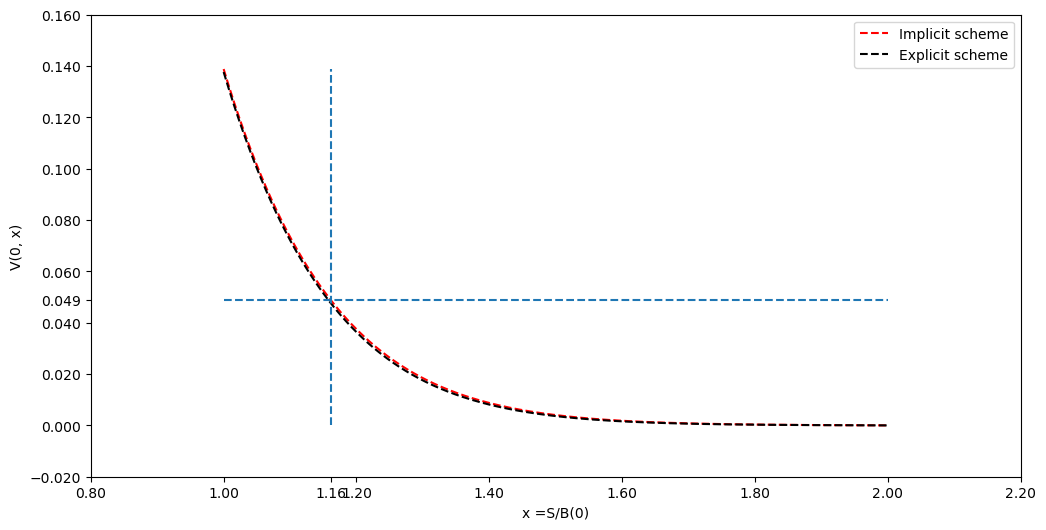

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(grid_x, V_implicit[:, 0], '--', color = "red", label = "Implicit scheme")
plt.plot(grid_x_explicit, V_explicit[:, 0], '--', color = 'black', label = "Explicit scheme")
plt.vlines(grid_x[index],ymin= 0, ymax=np.max(V_implicit[:, 0]), linestyles='dashed')
plt.hlines(V0_implicit,xmin= 1, xmax=2,  linestyles='dashed')
plt.yticks(list(plt.yticks()[0]) + [V0_implicit])
plt.xticks(list(plt.xticks()[0]) + [grid_x[index]])
plt.xlabel("x =S/B(0)")
plt.ylabel("V(0, x)")
plt.legend()
plt.show()


Compare the result of the time zero price of the option for an initial value of the stock given by $s_0$ with the values found by Tsitsilkis-Van Roy and Longstaff Schwartz method implemented in the beginning of this notebook. We note in particular that the Tsitsilkis Van Roy method seems to over estimate the value.

--------------------------------------------
-----------------------------------------------